In [1]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 7.2 MB/s eta 0:00:00


Load dataset

In [13]:
import numpy as np
import pandas as pd

df = pd.read_csv('/content/IMDB-Dataset.csv')
print(df.duplicated().sum())
df = df.drop_duplicates()

418


In [3]:
import re
import nltk
import string
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import contractions

stop = set(stopwords.words('english'))

#Expanding contractions (expanding shortened world)
def expand_contractions(text):
  return contractions.fix(text)


def preprocess_text(text):
  wl = WordNetLemmatizer()
  soup = BeautifulSoup(text, 'html.parser') #removing html tags
  text = soup.get_text()
  text = expand_contractions(text)
  emoji_clean = re.compile("["
                        u"\U0001F600-\U0001F64F" # emoticons
                        u"\U0001F300-\U0001F5FF" # symbols & pictographs
                        u"\U0001F680-\U0001F6FF" # transport & map symbols
                        u"\U0001F1E0-\U0001F1FF" # flags (iOS)
                        u"\U00002702-\U000027B0"
                        u"\U000024C2-\U0001F251"
                        "]+",flags =re.UNICODE)
  text = emoji_clean.sub(r'', text)
  text = re.sub(r'\.(?=\S)','. ',text) #add space after full stop
  text = re.sub(r'http\S+','',text) #remove urls
  text = "". join ([word.lower() for word in text if word not in string.punctuation]) # remove punctuation and make text lowercase
  text = " ".join([
      wl.lemmatize(word) for word in text.split () if word not in stop and word.isalpha() ]) # lemmatize
  return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [4]:
df['review'][0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [5]:
preprocess_text(df['review'][0])

'one reviewer mentioned watching oz episode hooked right exactly happened first thing struck oz brutality unflinching scene violence set right word go trust show faint hearted timid show pull punch regard drug sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focus mainly emerald city experimental section prison cell glass front face inwards privacy high agenda city home many aryan muslim gangsta latino christian italian irish scuffle death stare dodgy dealing shady agreement never far away would say main appeal show due fact go show would dare forget pretty picture painted mainstream audience forget charm forget romance oz mess around first episode ever saw struck nasty surreal could say ready watched developed taste oz got accustomed high level graphic violence violence injustice crooked guard sold nickel inmate kill order get away well mannered middle class inmate turned prison bitch due lack street skill prison experience watc

In [6]:
df['review'] = df['review'].apply(preprocess_text)

<ipython-input-3-dce27d191a7f>:20: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser') #removing html tags


3. EDA

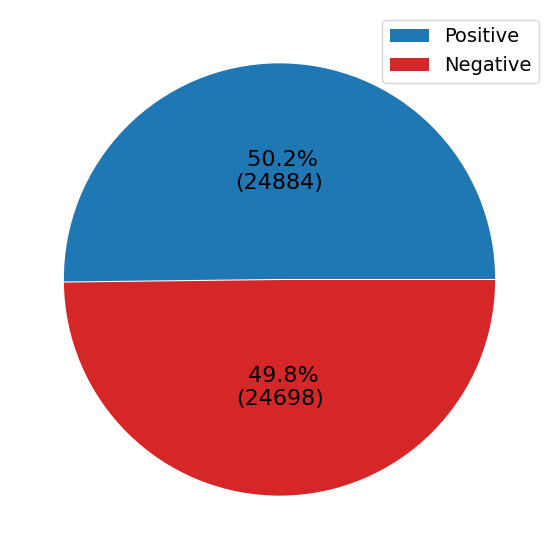

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

def func(pct, allvalues):
  absolute = int(pct / 100.* np.sum(allvalues) )
  return " {:.1f}%\n({:d})".format (pct , absolute )

freq_pos = len(df[df['sentiment'] == 'positive'])
freq_neg = len(df[df['sentiment'] == 'negative'])

data = [freq_pos , freq_neg]
labels = ['positive', 'negative']
pie , ax = plt.subplots(figsize =[11 ,7])
plt.pie(x=data , autopct=lambda pct: func(pct , data) , explode =[0.0025]*2,
        pctdistance =0.5, colors =[ sns.color_palette()[0] , 'tab:red'] , textprops ={'fontsize': 16})
labels = [r'Positive', r'Negative']
plt.legend(labels,loc ="best",prop ={'size': 14})
pie.savefig("PieChart .png")
plt.show()

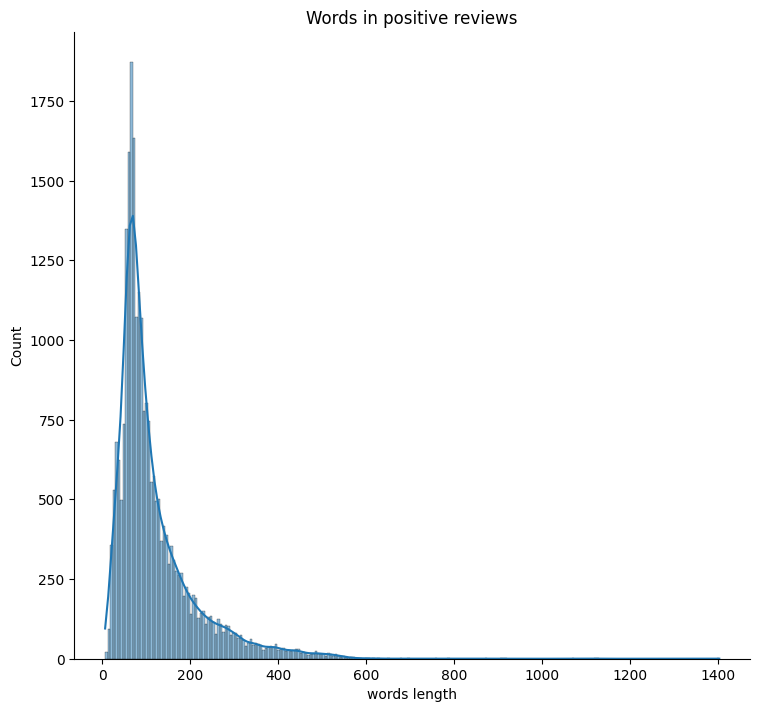

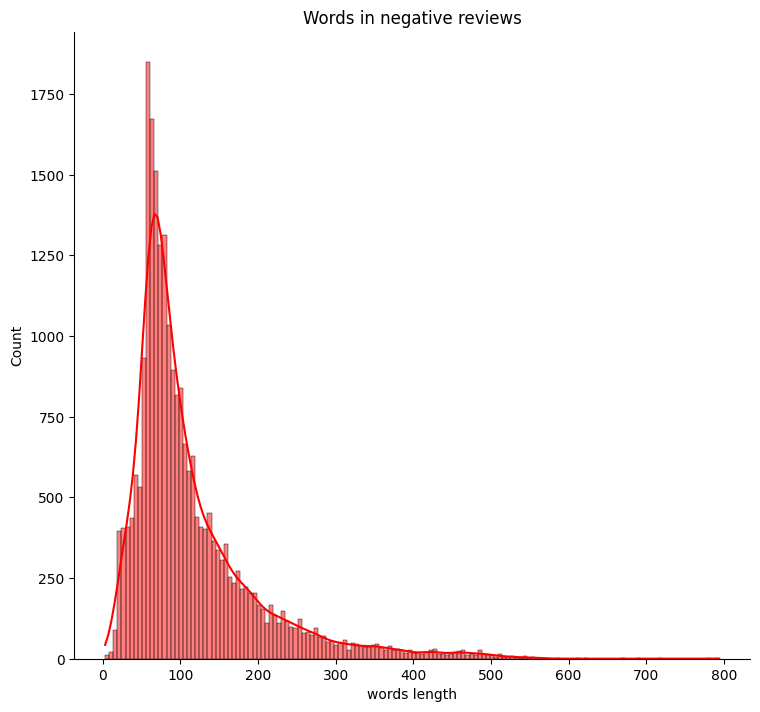

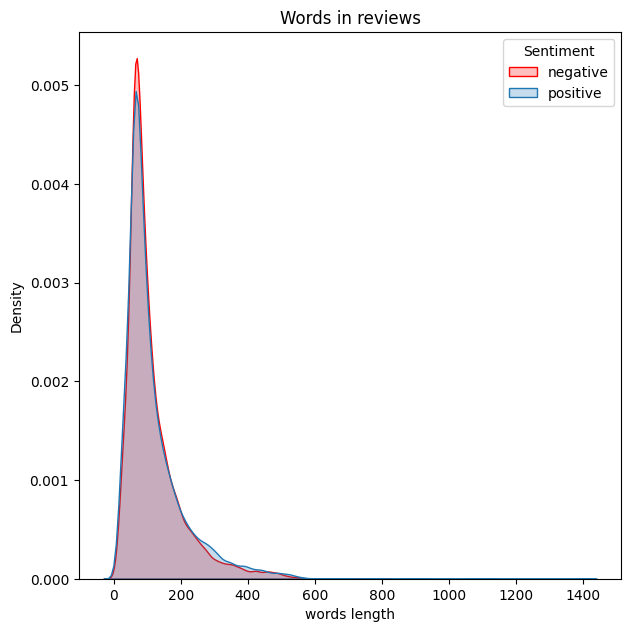

In [8]:
words_len = df['review'].str.split().map(lambda x : len(x))
df_temp = df.copy()
df_temp['words length'] = words_len

hist_positive = sns.displot(
    data=df_temp[df_temp['sentiment'] == 'positive'],
    x = "words length", hue='sentiment', kde=True, height=7, aspect=1.1, legend=False
).set(title='Words in positive reviews')
plt.show(hist_positive)
hist_negative = sns.displot(
    data=df_temp[df_temp['sentiment'] == 'negative'],
    x = "words length", hue='sentiment', kde=True, height=7, aspect=1.1, legend=False,palette=['red']
).set(title='Words in negative reviews')
plt.show(hist_negative)
plt.figure(figsize =(7,7.1))
kernel_distribution_number_words_plot = sns.kdeplot(
    data=df_temp, x="words length", hue="sentiment", fill=True, palette=[sns.color_palette()[0], 'red']
).set(title="Words in reviews")
plt.legend ( title ='Sentiment', labels =['negative','positive'])
plt.show(kernel_distribution_number_words_plot )

4. Train test split

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

label_encode = LabelEncoder()
y_data = label_encode.fit_transform(df['sentiment'])
x_data = df['review']
x_train , x_test , y_train , y_test = train_test_split (x_data , y_data , test_size =0.2 , random_state =42
)

5. Tranform text into Vector

In [10]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
tfidf_vectorizer.fit(x_train ,y_train )
x_train_encoded = tfidf_vectorizer.fit_transform(x_train)
x_test_encoded = tfidf_vectorizer.transform(x_test)

6. Train and Evaluate Model

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

dt_classifier = DecisionTreeClassifier(
    criterion='entropy',
    random_state=42
)
dt_classifier.fit(x_train_encoded , y_train)
y_pred = dt_classifier.predict(x_test_encoded)
accuracy_score(y_test , y_pred)

0.7180598971463145

In [12]:
rf_classifier = RandomForestClassifier(
    random_state=42
)
rf_classifier.fit(x_train_encoded , y_train)
y_pred = rf_classifier.predict(x_test_encoded)
accuracy_score(y_test , y_pred)

0.8420893415347384